<a href="https://colab.research.google.com/github/BBrain778/CNN/blob/renewing/data_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#主題:使用CNN分類衛星影像中的災害從而加速災害應對




## 1.1 安裝套件(若在colab訓練每次都需要執行)

In [2]:
!pip install fastbook -q

## 1.2 讀取套件

In [3]:
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import shutil
import fastai;
print('fastai verison:', fastai.__version__)
print('torch version:', torch.__version__)

fastai verison: 2.7.19
torch version: 2.6.0+cu124



## 1.3 準備資料集

In [5]:
#將 Google Drive 掛載到 /content/drive，以便存取或保存檔案
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#set project name
project = 'demo'

path = Path('/content/drive/MyDrive/DeepLearning/0225/dataset/'+project)

#Key is the name of classes; value is the keyword that which search engine uses for searching
keywords = {'Satellite photos of the fire': 'Satellite photos of the fire', 'Drought satellite photos': 'Drought satellite photos', 'Satellite photos of floods': 'Satellite photos of floods', 'Satellite photos of volcanic eruptions': 'Satellite photos of volcanic eruptions', 'Satellite photos of heavy rain': 'Satellite photos of heavy rain', 'Typhoon satellite photos': 'Typhoon satellite photos'}
array = keywords.items()
#Satellite photos of the fire火災衛星照片
#Drought satellite photos乾旱衛星照片
#Satellite photos of floods水災衛星照片
#Satellite photos of volcanic eruptions火山爆發衛星照片
#Satellite photos of heavy rain豪雨衛星照片
#Typhoon satellite photos颱風衛星照片

project_folder = f'/content/drive/MyDrive/DeepLearning/0225/dataset/{project}'

In [7]:
if not path.exists():
    !mkdir -p {project_folder}
else:
    print('The Project Folder exists; it will be removed and created again.')
    shutil.rmtree(project_folder)
    !mkdir -p {project_folder}

#網路爬蟲下載圖片
for key,value in array:
    print(key,value)
    dest = (path/key)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f' {value}',max_images=100)
    download_images(dest, urls=urls)

The Project Folder exists; it will be removed and created again.
Satellite photos of the fire Satellite photos of the fire
Drought satellite photos Drought satellite photos
Satellite photos of floods Satellite photos of floods
Satellite photos of volcanic eruptions Satellite photos of volcanic eruptions
Satellite photos of heavy rain Satellite photos of heavy rain
Typhoon satellite photos Typhoon satellite photos


## 1.4 清洗資料

In [8]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink) #unlink broken images

(#33) [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None...]

## 2.1 設定訓練資料路徑

In [9]:
path = Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo')
path.ls()

(#6) [Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of the fire'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Drought satellite photos'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of floods'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of volcanic eruptions'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of heavy rain'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Typhoon satellite photos')]

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#建立模型權重儲存路徑
myPath='/content/drive/MyDrive/DeepLearning/0225/models'
!mkdir -p $myPath

## 2.2 資料讀取框架

In [13]:
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #定義輸入和輸出的資料類型(輸入:圖片/輸出:分類標籤)
    get_items=get_image_files,  #告訴 fastai 如何獲取資料
    splitter=RandomSplitter(valid_pct=0.2, seed=42),#20%的資料用於驗證集，剩下的80%用於訓練集
    item_tfms=Resize(224),#將所有圖片調整為 224x224 像素
    get_y=parent_label,#從圖片的父資料夾名稱獲取標籤
)

#利用框架正式讀取資料
# 批次大小（batch size），每次訓練或驗證時處理 16 張圖片
# 使用 16 個工作線程來並行載入資料，加快資料準備速度（特別在 GPU 環境中很有用）
dls = dataset.dataloaders(path,bs=16,num_workers=16) #dataset.dataloaders 是從你的數據集（dataset）生成一個數據加載器



#讀取結果
print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds)) #dls.c=類別數量(5) dls.vocab=標籤詞彙表 len(dls.train_ds)=訓練樣本數量(80%) len(dls.valid_ds)=驗證數量(20%)
print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds))




6 ['Drought satellite photos', 'Satellite photos of floods', 'Satellite photos of heavy rain', 'Satellite photos of the fire', 'Satellite photos of volcanic eruptions', 'Typhoon satellite photos'] 410 102
6 ['Drought satellite photos', 'Satellite photos of floods', 'Satellite photos of heavy rain', 'Satellite photos of the fire', 'Satellite photos of volcanic eruptions', 'Typhoon satellite photos'] 410 102


## 2.3 讀取圖檔結果

訓練資料


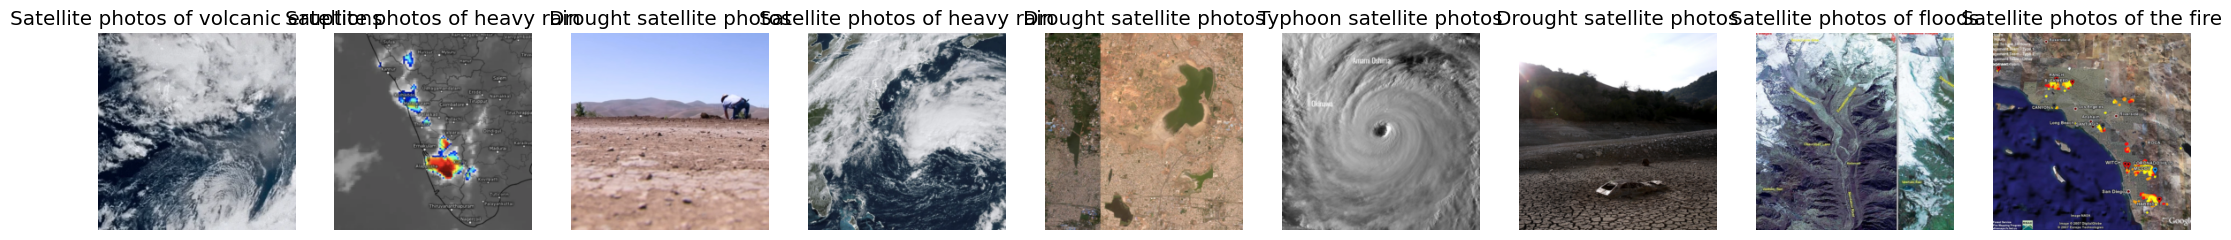

In [14]:
print('訓練資料')
dls.show_batch(max_n=9, nrows=1) #從訓練集中抽出9個樣本   nrows=顯示的行數
#這邊顯示出來的圖片和標籤是我提供給fastai的資料，不是模型自己預測的結果


## 3.1選擇模型架構以及對應的預測訓練權重

NOTE: metrics是模型訓練人員觀察的指標，可設定多個

In [15]:
# vision_learner是 fastai 庫中專門用於圖像視覺任務的函數，用來構建一個圖像分類模型
# dls 包含了訓練數據和驗證數據（通常是圖像數據及其標籤），並且已經被預處理，用來告訴模型“這些是我的數據，準備好用它們來訓練吧”
# resnet34 是模型的架構（architecture），具體來說是 ResNet-34，一種經典的卷積神經網絡（CNN），特別適合圖像分類任務
# metrics=[accuracy, error_rate]這些是在訓練過程中用來評估模型性能的指標
# pretrained=True表示使用預訓練的權重來初始化模型，ResNet-34 已經在 ImageNet（一個包含數百萬張圖像的大型數據集）上訓練過，因此它已經學會了識別圖像中的基本特徵（比如邊緣、形狀等）



learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], pretrained=True)
learn.fit_one_cycle(3, 1e-3)

#總結
#建了一個基於 ResNet-34 的圖像分類模型，準備用 dls 中的數據進行訓練，並且希望看到準確率和錯誤率作為評估指標。模型從預訓練權重開始，而不是從隨機初始化的權重開始



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.384563,1.062191,0.676471,0.323529,00:29
1,1.717175,1.032649,0.705882,0.294118,00:28
2,1.395682,0.998054,0.705882,0.294118,00:27


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## 3.2儲存第一次訓練好的權重

In [16]:
myModel=myPath+'/resnet_stage-1.pkl'
learn.export(myModel)

## 3.3解凍權重再次訓練

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

Minimum/10: 1.01e-04, steepest point: 8.39e-07


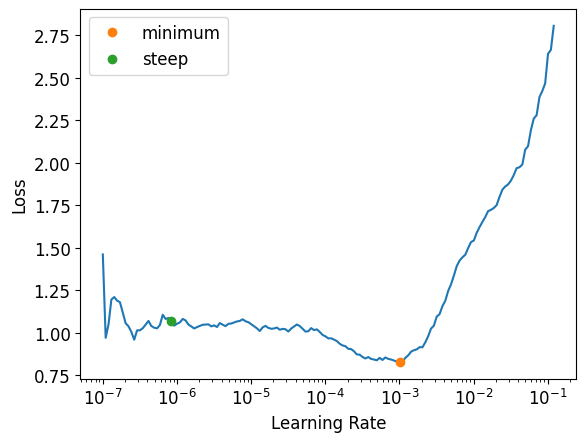

In [17]:
# 調整學習率（learning rate）的過程
learn.unfreeze()
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep), end_lr=5, num_it=200) #這行程式碼的作用是尋找一個最佳的學習率範圍，幫助你選擇一個能夠加快訓練並且穩定收斂的學習率

print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [18]:
learn.fit_one_cycle(6, lr_max=2.75e-04)
#用 One Cycle Learning Rate 策略進行 6 次訓練，並在訓練過程中將學習率最大值設置為 2.75e-04

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.070666,1.141261,0.715686,0.284314,00:28
1,0.934284,1.224251,0.676471,0.323529,00:28
2,0.801105,1.598020,0.666667,0.333333,00:28
3,0.659766,1.194425,0.784314,0.215686,00:28
4,0.525004,1.048447,0.774510,0.225490,00:28
5,0.389505,1.061477,0.754902,0.245098,00:29


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

## 3.4儲存新的權重

In [19]:
myModel=myPath+'/resnet_stage-2.pkl'
learn.export(myModel)

## 4.1結果檢核(Confusion Matrix)

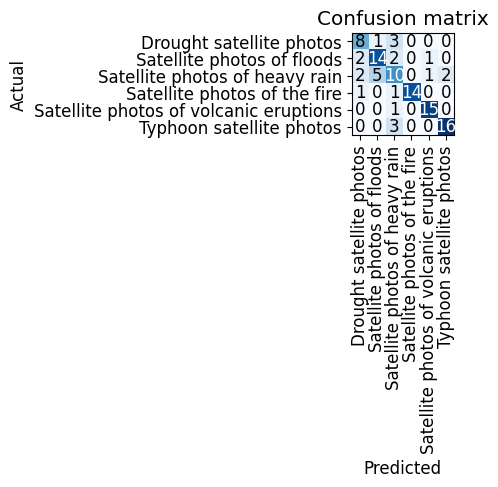

In [20]:
#contains interpretation methods for classification models
interp = ClassificationInterpretation.from_learner(learn)
#Plot the confusion matrix
interp.plot_confusion_matrix()

### 解釋一下confusion matrix
*   elephant (大象)：20/20，完全正確
*   giraffe (長頸鹿)：18/18，完全正確
*   hippo (河馬)：20/21，幾乎完全正確
*   zebra (斑馬)：19/19，完全正確
*   猴子 (monkey) 類別有誤分類
    *   14 張猴子圖片中，有 13 張正確分類，但 1 張被錯誤分類為河馬 (hippo)









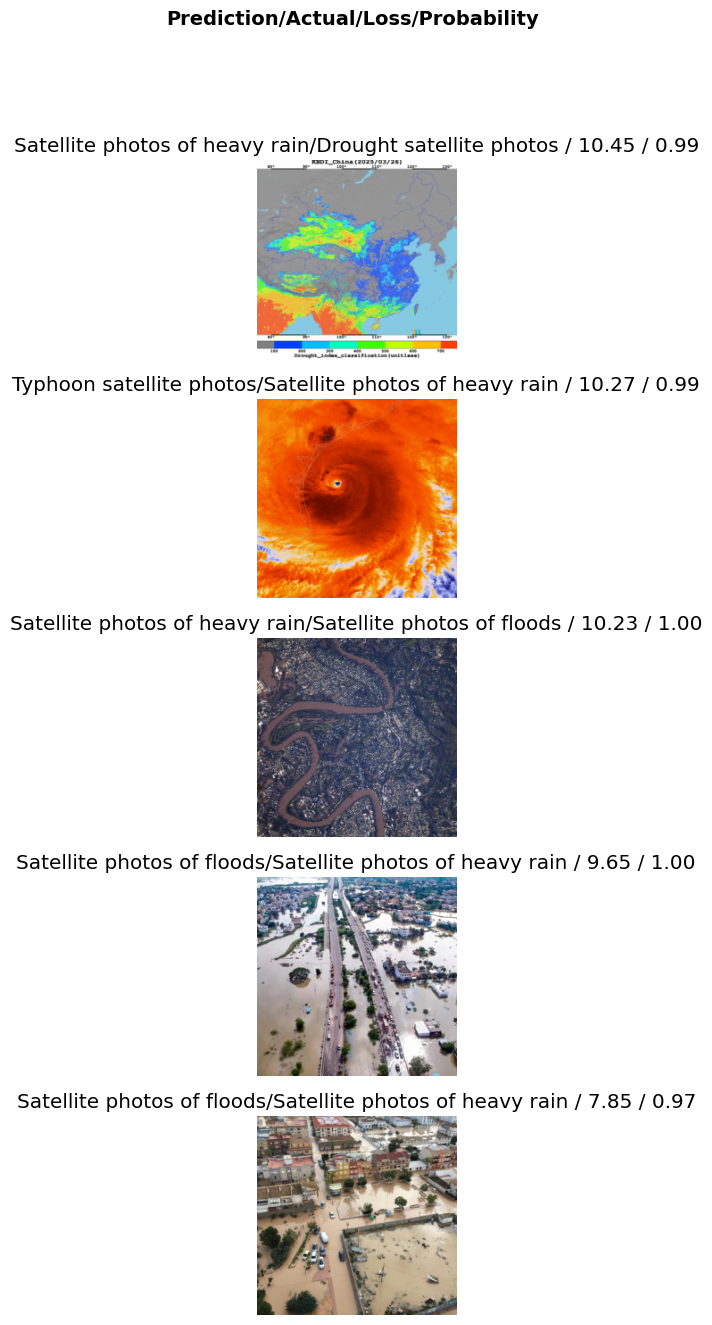

In [21]:
interp.plot_top_losses(5, nrows=5) #顯示前 5 個錯誤最嚴重的分類結果

## 預測

In [22]:
## 模型位置
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 5.1讀取先前訓練好的權重

In [23]:
myPath='/content/drive/MyDrive/DeepLearning/0225/models'
myModel=myPath+'/resnet_stage-2.pkl'
learn = load_learner(myModel)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


## 5.2讀取檔案並送入模型預測

In [24]:
##執行預測 -method I
# get_image_files is now available
fnames_fire = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of the fire')
fnames_Drought = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Drought satellite photos')
fnames_floods = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of floods')
fnames_volcanic = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of volcanic eruptions')
fnames_heavy_rain = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of heavy rain')
fnames_Typhoon = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Typhoon satellite photos')


print(f"Number of elephant images: {len(fnames_fire)}")
print(f"Number of elephant images: {len(fnames_Drought)}")
print(f"Number of elephant images: {len(fnames_floods)}")
print(f"Number of elephant images: {len(fnames_volcanic)}")
print(f"Number of elephant images: {len(fnames_heavy_rain)}")
print(f"Number of elephant images: {len(fnames_Typhoon)}")

Number of elephant images: 93
Number of elephant images: 81
Number of elephant images: 78
Number of elephant images: 92
Number of elephant images: 85
Number of elephant images: 83


In [25]:
# Check if the list has enough elements before accessing them
if len(fnames_fire) > 3:
    pred_class,pred_idx,outputs = learn.predict(fnames_fire[3])
    print("Actual: fire, Predicted = {}".format(pred_class))
else:
    print("fnames_fire does not have enough elements to access index 3")


Actual: fire, Predicted = Satellite photos of the fire


## ROC curve



*   橫軸是假陽性率（FPR），縱軸是真陽性率（TPR）
*   ROC 曲線（Receiver Operating Characteristic Curve，接收者操作特徵曲線）是一種用於評估分類模型性能的圖形工具，特別是在二元分類問題中（例如判斷「是/否」、「正/負」）
*   AUC（Area Under the Curve） 是 ROC 曲線下的面積，範圍從 0 到 1
*   AUC 的解釋
  *   AUC=1：完美模型，100%正確分類。
  *   AUC=0.5：隨機猜測，模型毫無區分能力（ROC 曲線是一條對角線）。
  *   AUC<0.5：模型比隨機猜測還差（可能是標籤錯誤或模型反向預測）。











/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


The accuracy is 75.49 %.


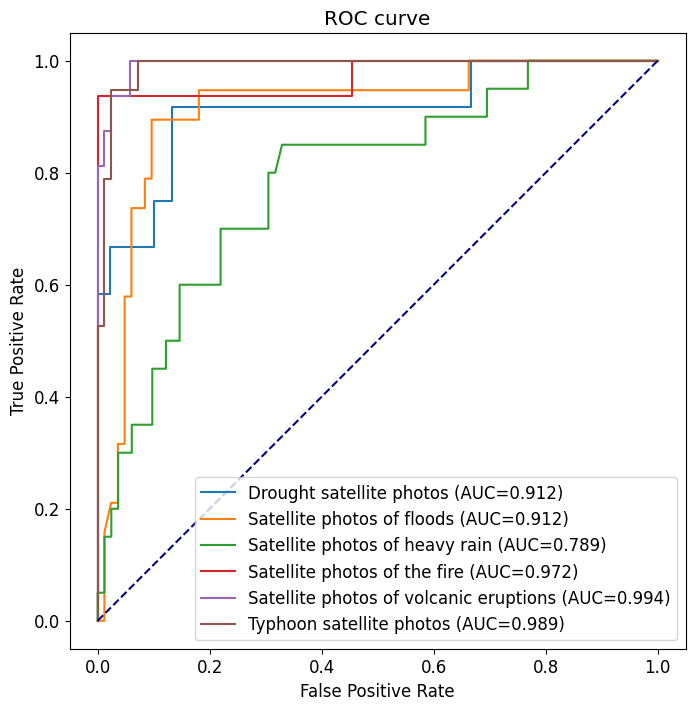

In [26]:
from sklearn.metrics import roc_curve, auc

preds, y, loss = learn.get_preds(with_loss=True)
preds, y = learn.get_preds(dl=dls.valid)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8, 8))
for i in range(class_num) :
  probs = np.array(preds[:, i])
  #compute ROC curve
  fpr, tpr, thresholds = roc_curve(y, probs, pos_label=i)
  #compute area under the curve
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format( class_name[i], round(roc_auc, 3)))

plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")

##6.Visualization with Frad-CAM

Class Activation Mapping（類激活映射，簡稱CAM）是一種用於解釋卷積神經網路（CNN）預測的可視化技術。它可以幫助我們理解CNN在圖像分類任務中，哪些區域對最終預測貢獻最大。簡單來說，CAM生成一個熱圖（heatmap），顯示圖像中哪些部分對某個特定類別的預測最重要。



In [27]:
class Hook():
  def __init__(self,m):
    self.hook = m.register_forward_hook(self.hook_fn)
  def hook_fn(self,m,i,o):self.stored = o.detach().clone()
  def __enter__(self, *args):return self
  def __exit__(self, *args):self.hook.remove()

In [28]:
class HookBwd():
  def __init__(self,m):
    self.hook = m.register_backward_hook(self.hook_fn)
  def hook_fn(self,m,gi,go):self.stored = go[0].detach().clone()
  def __enter__(self, *args):return self
  def __exit__(self, *args):self.hook.remove()

##讀取要繪製的影像

In [29]:
fnames_fire = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of the fire')
test_dl = learn.dls.test_dl(fnames_fire, with_labels=True)

fnames_Drought = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Drought satellite photos')
test_dl = learn.dls.test_dl(fnames_Drought, with_labels=True)

fnames_floods = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of floods')
test_dl = learn.dls.test_dl(fnames_floods, with_labels=True)

fnames_volcanic = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of volcanic eruptions')
test_dl = learn.dls.test_dl(fnames_volcanic, with_labels=True)

fnames_heavy_rain = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Satellite photos of heavy rain')
test_dl = learn.dls.test_dl(fnames_heavy_rain, with_labels=True)



In [30]:
from torchvision.transforms.functional import to_tensor
from fastai.vision.all import PILImage, Resize, ResizeMethod, PadMode  # 導入 fastai 模組
fn = test_dl.items[1] #第2張影像
x_dec = PILImage.create(fn);

#Resize : 224填充黑邊
rsz = Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
x_dec = rsz(x_dec)
x = to_tensor(x_dec)
x.unsqueeze_(0)
x.shape,type(x)


(torch.Size([1, 3, 224, 224]), torch.Tensor)

##繪製最後一層的feature map 的Grad-CAM

In [31]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    #output = learn.model.eval()(x,cuda())
    output = learn.model.eval()(x.cpu())
    act = hook.stored
  output[0,cls].backward()
  grad = hookg.stored



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [32]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

##Demo

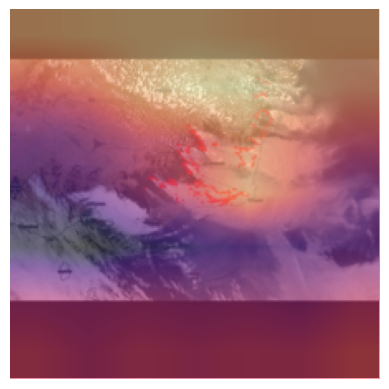

In [33]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
           interpolation='bilinear', cmap='magma')
